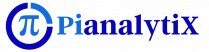

## Dog Breed Prediction

In this project, we will see how to use Keras and TensorFlow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically a multiclass classification problem.

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"somchaikdt","key":"c45212ac452e67c9d7c09699f915ec30"}'}

We will start by connecting to Kaggle using Kaggle API which can be downloaded from your Kaggle account's settings and uploading it here(upload box).

In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

Next we will install Kaggle API using pip installation.

In [2]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Setting up Kaggle using Kaggle API.

In [3]:
# Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


To store the data we will create a new directory and make it as current working directory.

In [4]:
# Searching for dataset
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           4892          8  0.1764706        


Searching Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [5]:
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

 99% 684M/691M [00:06<00:00, 143MB/s]
100% 691M/691M [00:06<00:00, 104MB/s]
/content


After searching the data next step would be downloading the data into collab notebook using references found in search option.

In [6]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

We will unzip the data which is downloaded and remove the irrelevant files.

In [7]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# tqdm is a library in Python that provides a fast, extensible progress bar for
# loops and other iterable processes. When you use from tqdm import tqdm,
# you are importing the tqdm class, which you can then use to wrap an iterable
# and create a progress bar for it. This can be particularly useful when you have
# long-running tasks or loops, as it gives you a visual indication of the progres
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam

Importing required libraries.

In [8]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv("dog_dataset/labels.csv")
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Loading the labels data into dataframe and viewing it. Here we analysed that labels contains 10222 rows and 2 columns.  

In [9]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

Here we are finding out the count per class i.e. total data in each class using value_counts() function.

In [10]:
# Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound','maltese_dog','bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


We will work on only 3 breeds due to limited computational power. You can consider more classes as per your system computational power.

In [11]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):

    # target_size=(224, 224): resizes the image to a standard size of 224x224 pixels.
    # %s for keep 'labels['id'][i]' as string format
    # For example  labels['id'][i] holds the value '00123', the resulting path becomes:
    #         'dog_dataset/train/00123.jpg'
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)

    x = np.expand_dims(img.copy(), axis=0)
    # Normalizing pixel values  to avoid the possibility of exploding gradients
    # because of the high range of the pixels [0, 255], and improve the convergence speed.
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 509.86it/s]


Train Images shape:  (357, 224, 224, 3)  size: 53,738,496
One-hot encoded output shape:  (357, 3)  size: 1,071


In [12]:
357*224*224*3

53738496

As we are working with the classification dataset first we need to one hot encode the target value i.e. the classes. After that we will read images and convert them into numpy array and finally normalizing the array.

In [ ]:
# Building the Model
model = Sequential()

# CNNs
#                 num of filter, filter size
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

# NNs
model.add(Flatten())
model.add(Dense(128, activation = "relu", kernel_regularizer = 'l2'))
model.add(Dense(64, activation = "relu", kernel_regularizer = 'l2'))
# Output layer should be softmax activation because we classify multiclasses.
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

#                                                          learning rate (lr)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)        0

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


After defining the network architecture we found out the total parameters as 162,619.

In [ ]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

After defining the network architecture we will start with splitting the test and train data then dividing train data in train and validation data.

In [ ]:
# Training the model
epochs = 130
batch_size = 100

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/130
3/3 [==============================] - 17s 2s/step - loss: 4.8758 - accuracy: 0.3203 - val_loss: 4.8489 - val_accuracy: 0.3692
Epoch 2/130
3/3 [==============================] - 0s 158ms/step - loss: 4.8363 - accuracy: 0.3828 - val_loss: 4.8104 - val_accuracy: 0.4462
Epoch 3/130
3/3 [==============================] - 0s 167ms/step - loss: 4.7973 - accuracy: 0.4375 - val_loss: 4.7723 - val_accuracy: 0.4769
Epoch 4/130
3/3 [==============================] - 0s 157ms/step - loss: 4.7581 - accuracy: 0.4922 - val_loss: 4.7347 - val_accuracy: 0.4769
Epoch 5/130
3/3 [==============================] - 0s 166ms/step - loss: 4.7189 - accuracy: 0.4883 - val_loss: 4.6969 - val_accuracy: 0.4923
Epoch 6/130
3/3 [==============================] - 0s 158ms/step - loss: 4.6794 - accuracy: 0.5117 - val_loss: 4.6585 - val_accuracy: 0.5077
Epoch 7/130
3/3 [==============================] - 0s 160ms/step - loss: 4.6380 - accuracy: 0.5117 - val_loss: 4.6170 - val_accuracy: 0.5077
Epoch 8/130
3/3

Now we will train our model on 100 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

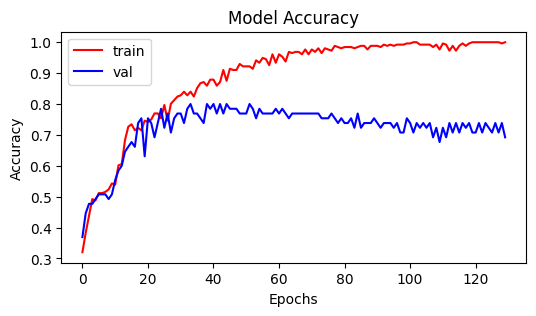

In [ ]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Here we analyse how the model is learning with each epoch in terms of accuracy.

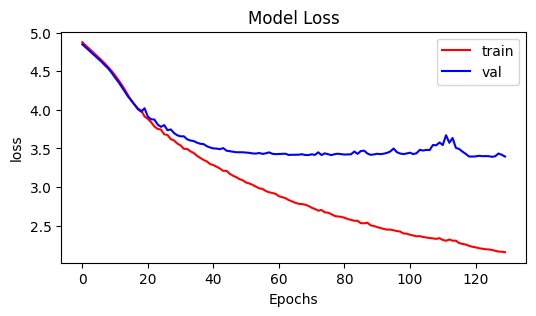

In [ ]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Here we analyse how the model is learning with each epoch in terms of loss.

In [ ]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 9ms/step - loss: 3.6073 - accuracy: 0.6944
Accuracy over the test set: 
  69.44 %


We will use predict function to make predictions using this model also we are finding out the accuracy on the test set.

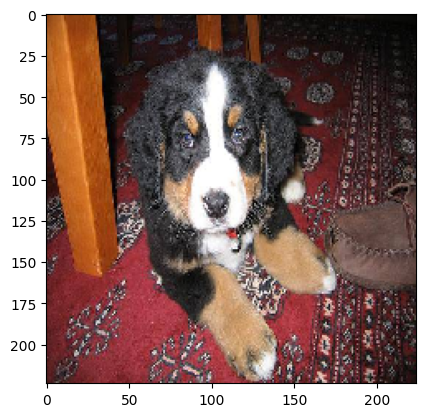

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [ ]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

Here you can see image with its original and predicted label.

## Conclusion:

We started with downloading the dataset creating the model and finding out the predictions using the model. We can optimize different hyper parameters in order to tune this model for a higher accuracy. This model can be used to predict different breeds of dogs which can be further used by different NGO's working on saving animals and for educational purposes also.

From normal architech of convolutional neuron network (CNNs) will chance to vanishing and exploding gradient problem (When add #layer until certain point. The performance will increasing then after certain point will going to decrease the performance) when CNNs get more deeper. So I will try to use VGG Architecture for reduce that problem.

- Modified by Somchai.K

In [13]:
from keras.applications import VGG16
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load pre-trained VGG16 model
# include_top: whether to include the 3 fully-connected layers at the top of the network.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))  # Adjust the number of classes based on your dataset

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17934531 (68.41 MB)
Trainable params: 3219843 (12.28 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

In [14]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [15]:
# Training the model
epochs = 30
batch_size = 100

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/30
3/3 [==============================] - 50s 15s/step - loss: 1.1168 - accuracy: 0.3633 - val_loss: 1.0208 - val_accuracy: 0.4462
Epoch 2/30
3/3 [==============================] - 1s 453ms/step - loss: 0.8556 - accuracy: 0.7227 - val_loss: 0.8986 - val_accuracy: 0.6000
Epoch 3/30
3/3 [==============================] - 1s 468ms/step - loss: 0.6183 - accuracy: 0.8828 - val_loss: 0.7017 - val_accuracy: 0.7692
Epoch 4/30
3/3 [==============================] - 1s 478ms/step - loss: 0.4353 - accuracy: 0.9570 - val_loss: 0.6721 - val_accuracy: 0.7385
Epoch 5/30
3/3 [==============================] - 1s 476ms/step - loss: 0.2959 - accuracy: 0.9805 - val_loss: 0.5690 - val_accuracy: 0.7385
Epoch 6/30
3/3 [==============================] - 1s 481ms/step - loss: 0.2026 - accuracy: 0.9922 - val_loss: 0.5393 - val_accuracy: 0.7692
Epoch 7/30
3/3 [==============================] - 1s 477ms/step - loss: 0.1416 - accuracy: 1.0000 - val_loss: 0.5129 - val_accuracy: 0.7846
Epoch 8/30
3/3 [=====

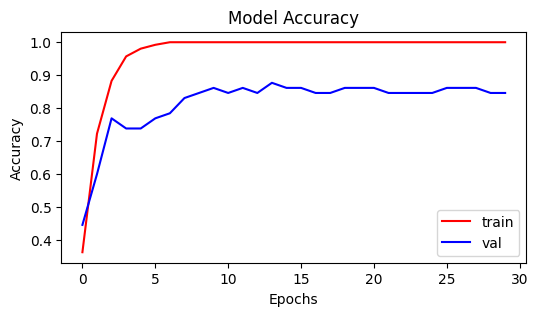

In [16]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

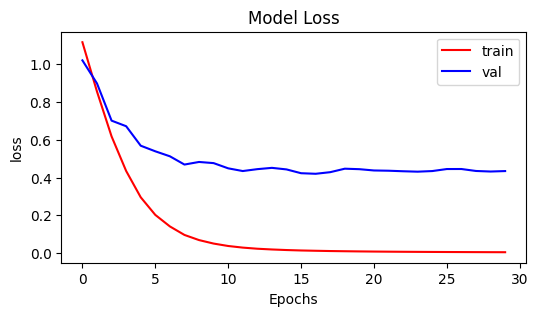

In [17]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [19]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 45ms/step - loss: 0.3857 - accuracy: 0.8611
Accuracy over the test set: 
  86.11 %


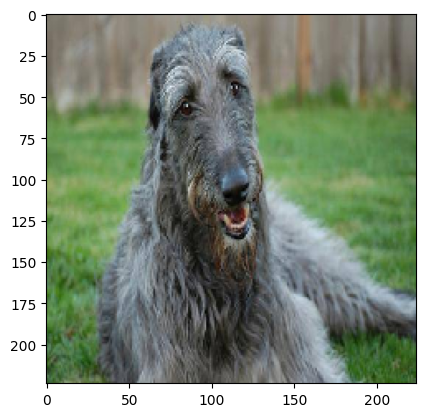

Originally :  scottish_deerhound
Predicted :  scottish_deerhound


In [20]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

### Save model

In [21]:
model.save('dog_breed.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
